In [2]:
# basic
import pandas as pd
import numpy as np
import ast
import json

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [3]:
# convert string to dictionary
def to_dict(attribute):
    try:
        if attribute != None:
            return ast.literal_eval(attribute)
        else:
            return ast.literal_eval("{}")
    except Exception as ex:
        print(ex)

In [4]:
# importing restaurants
restaurant = pd.read_csv('restaurant.csv')

In [5]:
# expand out attributes and make them their own columns
restaurant['attributes'] = restaurant['attributes'].replace(r'^\s*$', np.nan, regex=True)
restaurant['attributes'] = restaurant['attributes'].where(pd.notnull(restaurant['attributes']), None)
attributes_dict = [to_dict(x) for x in restaurant['attributes']]
attributes = pd.DataFrame(attributes_dict)

pd.set_option('display.max_columns', None)

In [6]:
# expand out nested dictionaries like GoodForMeal and Ambience
attributes['GoodForMeal'] = attributes['GoodForMeal'].where(pd.notnull(attributes['GoodForMeal']), None)
gfm_dict = [to_dict(x) for x in attributes['GoodForMeal']]
gfm = pd.json_normalize(gfm_dict)
# print(gfm)

attributes['Ambience'] = attributes['Ambience'].where(pd.notnull(attributes['Ambience']), None)
a_dict = [to_dict(x) for x in attributes['Ambience']]
a = pd.json_normalize(a_dict)
# print(a)

attributes['BusinessParking'] = attributes['BusinessParking'].where(pd.notnull(attributes['BusinessParking']), None)
bp_dict = [to_dict(x) for x in attributes['BusinessParking']]
bp = pd.json_normalize(bp_dict)
# print(bp)

attributes['BestNights'] = attributes['BestNights'].where(pd.notnull(attributes['BestNights']), None)
bn_dict = [to_dict(x) for x in attributes['BestNights']]
bn = pd.json_normalize(bn_dict)
bn = bn.rename(columns={'monday': 'monday_bn', 'tuesday': 'tuesday_bn', 
                        'wednesday': 'wednesday_bn', 'thursday': 'thursday_bn', 
                        'friday': 'friday_bn', 'saturday': 'saturday_bn', 'sunday': 'sunday_bn'})
# print(bn)

attributes['Music'] = attributes['Music'].where(pd.notnull(attributes['Music']), None)
m_dict = [to_dict(x) for x in attributes['Music']]
m = pd.json_normalize(m_dict)
# print(m)

attributes['DietaryRestrictions'] = attributes['DietaryRestrictions'].where(pd.notnull(attributes['DietaryRestrictions']), None)
dr_dict = [to_dict(x) for x in attributes['DietaryRestrictions']]
dr = pd.json_normalize(dr_dict)
# print(dr)

# drop col in attributes
attributes = attributes.drop(['GoodForMeal', 'Ambience', 'BusinessParking', 'BestNights', 'Music', 'DietaryRestrictions'], 
                             axis=1)

# fuse together
attributes = pd.concat([attributes, gfm, a, bp, bn, m, dr], axis=1)

attributes

,BikeParking,OutdoorSeating,RestaurantsPriceRange2,WiFi,RestaurantsTakeOut,RestaurantsReservations,Alcohol,BusinessAcceptsCreditCards,HappyHour,RestaurantsTableService,HasTV,Caters,BYOB,Corkage,BusinessAcceptsBitcoin,WheelchairAccessible,RestaurantsDelivery,DogsAllowed,GoodForKids,RestaurantsGoodForGroups,RestaurantsAttire,NoiseLevel,DriveThru,BYOBCorkage,Smoking,GoodForDancing,CoatCheck,ByAppointmentOnly,AgesAllowed,Open24Hours,RestaurantsCounterService,AcceptsInsurance,HairSpecializesIn,dessert,latenight,lunch,dinner,brunch,breakfast,touristy,hipster,romantic,intimate,trendy,upscale,classy,casual,divey,garage,street,validated,lot,valet,monday_bn,tuesday_bn,wednesday_bn,thursday_bn,friday_bn,saturday_bn,sunday_bn,dj,background_music,no_music,jukebox,live,video,karaoke,dairy-free,gluten-free,vegan,kosher,halal,soy-free,vegetarian
0,True,False,2,u'free',True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,False,NaN,u'free',True,True,u'full_bar',True,True,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,False,NaN,u'free',True,NaN,u'full_bar',True,True,True,True,True,False,False,False,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,True,None,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,True,1,NaN,True,False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,True,True,'casual',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,True,1,'free',True,False,'none',True,False,False,True,False,NaN,NaN,NaN,True,True,True,True,True,'casual',u'average',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,False,True,3,u'no',None,True,u'full_bar',True,NaN,NaN,True,False,NaN,NaN,NaN,NaN,None,False,False,True,'dressy',u'average',None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39996,False,False,2,u'free',True,True,u'full_bar',True,False,True,True,False,NaN,NaN,False,True,False,False,True,True,u'casual',u'average',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,False,False,True,False,False,False,False,None,None,False,None,None,True,False,False,False,False,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39997,True,True,2,u'free',True,True,u'full_bar',NaN,True,True,False,False,False,True,NaN,True,True,True,False,False,u'casual',u'average',NaN,NaN,u'no',False,False,False,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False,False,True,False,NaN,False,True,False,False,False,False,False,False,False,False,True,False,False,Fa

In [7]:
# one hot encode attributes
df = pd.get_dummies(attributes)
print(df)

counts = {}
for col in df:
    counts[col] = df[col].sum()
    
# sort
counts = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
# print(counts)

# drop any col with sum < 10000
for col in df:
    if df[col].sum() < 10000:
        df.drop(col, axis=1, inplace=True)

attributes = df
attributes

       BikeParking_False  BikeParking_None  BikeParking_True  \
0                      0                 0                 1   
1                      0                 0                 0   
2                      0                 0                 1   
3                      0                 0                 0   
4                      0                 0                 1   
...                  ...               ...               ...   
39995                  1                 0                 0   
39996                  1                 0                 0   
39997                  0                 0                 1   
39998                  1                 0                 0   
39999                  0                 0                 0   

       OutdoorSeating_False  OutdoorSeating_None  OutdoorSeating_True  \
0                         1                    0                    0   
1                         1                    0                    0   
2           

,BikeParking_True,OutdoorSeating_False,OutdoorSeating_True,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,WiFi_u'free',RestaurantsTakeOut_True,RestaurantsReservations_False,RestaurantsReservations_True,Alcohol_u'none',BusinessAcceptsCreditCards_True,HasTV_True,Caters_False,Caters_True,RestaurantsDelivery_False,RestaurantsDelivery_True,GoodForKids_True,RestaurantsGoodForGroups_True,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',NoiseLevel_u'average',dessert_False,latenight_False,lunch_True,dinner_False,dinner_True,brunch_False,breakfast_False,touristy_False,hipster_False,romantic_False,intimate_False,trendy_False,upscale_False,classy_False,casual_False,casual_True,divey_False,garage_False,street_False,validated_False,lot_False,lot_True,valet_False
0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,1
1,0,1,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1
2,1,1,0,0,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1
3,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0
4,1,0,1,1,0,0,1,1,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0,1,0,1,1,1,1,1,0,1,1,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,0
39996,0,1,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,1,0,1,0,0,1,1,1,1,1,0,0,1,0,0,0,1,1,1,1,1,0,1,1
39997,1,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,0,1,1,0,1
39998,0,1,0,1,0,0,1,1,0,1,1,1,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1


In [8]:
# expand out categories and make them their own columns
# categories = pd.Series(restaurant['categories']).str.get_dummies(',')
# # drop columns that only contain zeros or 1
# categories = categories.loc[:, (categories != 0).any(axis=0)]
# categories

# expand out categories and make them their own columns
categories = pd.Series(restaurant['categories']).str.get_dummies(', ')

def toList(cat):
    return [x.strip() for x in cat.split(',')]

def toSeries(series):
    return pd.Series(x for _list in series for x in _list)

# categories
resCategories = restaurant['categories']
#categories
resCategories = resCategories.apply(toList)
resCategories = toSeries(resCategories)

cat = {}
for _, val in resCategories.items():
    if val in cat:
        cat[val] +=1
    else:
        cat.update({val:1})
        
cat = dict(sorted(cat.items(), key=lambda item: item[1]))

res = {key : val for key, val in cat.items() if not (isinstance(val, int) and (val < 1000))}

catKeys = list(res.keys())
catKeys.remove('Restaurants')
catKeys

categories = categories[catKeys]
categories

,Cocktail Bars,Pubs,Diners,Steakhouses,Asian Fusion,Barbeque,Sushi Bars,Sports Bars,Japanese,Desserts,Bakeries,Specialty Food,Caterers,Delis,Cafes,Chicken Wings,Event Planning & Services,Salad,Chinese,Seafood,Coffee & Tea,Italian,Mexican,Burgers,American (New),Breakfast & Brunch,Fast Food,Pizza,American (Traditional),Bars,Sandwiches,Nightlife,Food
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39996,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
39997,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1
39998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
# fuse into one whole table and drop attributes, categories
restaurant = restaurant.drop(["attributes", "categories", "hours"], axis=1)
restaurant = pd.concat([restaurant, attributes, categories], axis=1)
restaurant

,Unnamed: 0,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,BikeParking_True,OutdoorSeating_False,OutdoorSeating_True,RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,WiFi_u'free',RestaurantsTakeOut_True,RestaurantsReservations_False,RestaurantsReservations_True,Alcohol_u'none',BusinessAcceptsCreditCards_True,HasTV_True,Caters_False,Caters_True,RestaurantsDelivery_False,RestaurantsDelivery_True,GoodForKids_True,RestaurantsGoodForGroups_True,RestaurantsAttire_'casual',RestaurantsAttire_u'casual',NoiseLevel_u'average',dessert_False,latenight_False,lunch_True,dinner_False,dinner_True,brunch_False,breakfast_False,touristy_False,hipster_False,romantic_False,intimate_False,trendy_False,upscale_False,classy_False,casual_False,casual_True,divey_False,garage_False,street_False,validated_False,lot_False,lot_True,valet_False,Cocktail Bars,Pubs,Diners,Steakhouses,Asian Fusion,Barbeque,Sushi Bars,Sports Bars,Japanese,Desserts,Bakeries,Specialty Food,Caterers,Delis,Cafes,Chicken Wings,Event Planning & Services,Salad,Chinese,Seafood,Coffee & Tea,Italian,Mexican,Burgers,American (New),Breakfast & Brunch,Fast Food,Pizza,American (Traditional),Bars,Sandwiches,Nightlife,Food
0,126141,9XotjNYdPzWCokrVMRo4Mg,The Great Canadian Bagel,"120 Wye Road, Unit 101",Sherwood Park,AB,T8A 6P2,53.512479,-113.327738,4.0,9,1,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1
1,8518,Y92Nc9GhuXWvIABqNtSWGA,Tavern 52,329 Kennett Pike,Mendenhall,PA,19357,39.853403,-75.640789,3.5,21,1,0,1,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0
2,11669,b5byt9ewnM1U57ygWTTV2g,Crab Du Jour - Delran,4000 US-130,Delran,NJ,08075,40.011577,-74.961777,3.0,25,1,1,1,0,0,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,116916,4jICs7no7322VjY4hqHVAg,La Cocinita Cubana,113 Central Dr,Brandon,FL,33510,27.939235,-82.292208,4.5,33,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,1,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,66207,pWDE_rueENu_f5HKA_AsWw,Dune Coffee Roasters - Storke,250 A Storke Rd,Goleta,CA,93117,34.429540,-119.869271,4.0,159,1,1,0,1,1,0,0,1,1,0,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,1,0,1,0,1,0,1,1,1,1,1,0,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,141107,guwb1zuNEMtJVproo0ntFw,La Boca,870 Tchoupitoulas St,New Orleans,LA,70130,29.943455,-90.067341,4.0,420,1,0,0,1,0,0,0,0,0,1,0,1,1,1,0,0,0,0,1,0,0,1,1,1,0,0,1,1,1,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
39996,66695,-78Va3llKcPbL6SW4is8lw,Mungo's Italian Eatery,100 East Main St,Collinsville,IL,62234,38.669906,-89.985827,4.0,124,1,0,1,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,1,0,1,0,0,1,1,1,1,1,0,0,1,0,0,0,1,1,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
39997,101198,2pj5byDMoMDu-d0bTu2Sew,Pip,10403 83 Ave NW,Edmonton,AB,T6E 2C7,53.518958,-113.497891,4.0,117,1,1,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0,0,0,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1
39998,124342,RKRy17pwMJAbehSkZglwjw,Jia's Wok,477 E Plumb Ln,Reno,NV,89502,39.506363,-119.797213,3.0,35,1,0,1,0,1,0,0,1,1,0,1,1,1,1,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,

In [11]:
# creating x
x = restaurant.loc[:, 'review_count':]
# can change to whatever amount we consider as "good"
y = restaurant['stars'].apply(lambda x: 1 if x>=4 else 0)

# split!
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

dataColumns = xTrain.columns

# normalize
scaler = StandardScaler()
scaler.fit(xTrain)

xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

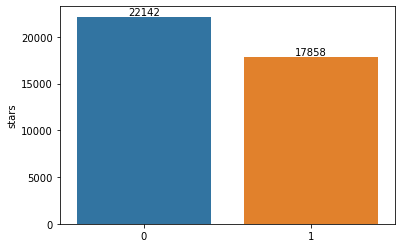

In [12]:
ax = sns.barplot(x=y.value_counts().index, y=y.value_counts())
for i in ax.containers:
    ax.bar_label(i,)

In [10]:
# KNN classifier
knn = KNeighborsClassifier()
knn.fit(xTrain, yTrain)

# predict
yHat = knn.predict(xTest)

# results
knn_accuracy = accuracy_score(yTest, yHat)
report = classification_report(yTest, yHat, digits=3)

print("accuracy: ", knn_accuracy)
print("Report:")
print(report)

accuracy:  0.6715833333333333
Report:
              precision    recall  f1-score   support

           0      0.688     0.738     0.712      6613
           1      0.647     0.590     0.617      5387

    accuracy                          0.672     12000
   macro avg      0.668     0.664     0.665     12000
weighted avg      0.670     0.672     0.670     12000



In [11]:
# KNN Hyperparameter Tuning
grid_params = {'n_neighbors': [5,7,9,11,13,15],
              'weights': ['uniform', 'distance'],
              'metric': ['minkowski', 'euclidean', 'manhattan']}

grid = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1, cv=3, n_jobs=3)
grid.fit(xTrain, yTrain)
gridHat = grid.predict(xTest)

# results
grid_accuracy = accuracy_score(yTest, gridHat)
grid_report = classification_report(yTest, gridHat, digits=3)

print(grid.best_params_)
print("accuracy: ", grid_accuracy)
print("Grid Report:")
print(grid_report)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}
accuracy:  0.68825
Grid Report:
              precision    recall  f1-score   support

           0      0.696     0.771     0.732      6613
           1      0.676     0.587     0.628      5387

    accuracy                          0.688     12000
   macro avg      0.686     0.679     0.680     12000
weighted avg      0.687     0.688     0.685     12000



In [19]:
# Decision Tree classifier
dt = DecisionTreeClassifier()
dt.fit(xTrain, yTrain)

# predict
yHat = dt.predict(xTest)

# results
dt_accuracy = accuracy_score(yTest, yHat)
report = classification_report(yTest, yHat, digits=3)

print("accuracy: ", dt_accuracy)
print("Report:")
print(report)

accuracy:  0.62325
Report:
              precision    recall  f1-score   support

           0      0.657     0.659     0.658      6596
           1      0.582     0.580     0.581      5404

    accuracy                          0.623     12000
   macro avg      0.619     0.619     0.619     12000
weighted avg      0.623     0.623     0.623     12000



In [20]:
# Decision Tree Hyperparameter Tuning
grid_params = {'max_depth': [2,3,5,10,20],
              'min_samples_leaf': [5,10,20,50,100],
              'criterion': ['gini', 'entropy']}
grid = GridSearchCV(DecisionTreeClassifier(), grid_params, verbose=1, cv=3, n_jobs=3)
grid.fit(xTrain, yTrain)
gridHat = grid.predict(xTest)

# results
grid_accuracy = accuracy_score(yTest, gridHat)
grid_report = classification_report(yTest, gridHat, digits=3)

print(grid.best_params_)
print("accuracy: ", grid_accuracy)
print("Grid Report:")
print(grid_report)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 100}
accuracy:  0.67525
Grid Report:
              precision    recall  f1-score   support

           0      0.701     0.713     0.707      6596
           1      0.642     0.630     0.636      5404

    accuracy                          0.675     12000
   macro avg      0.672     0.671     0.671     12000
weighted avg      0.675     0.675     0.675     12000



In [21]:
# Logistic Regression classifier
lr = LogisticRegression()
lr.fit(xTrain, yTrain)

# predict
yHat = lr.predict(xTest)

# results
lr_accuracy = accuracy_score(yTest, yHat)
report = classification_report(yTest, yHat, digits=3)

print("accuracy: ", lr_accuracy)
print("Report:")
print(report)

accuracy:  0.69625
Report:
              precision    recall  f1-score   support

           0      0.715     0.743     0.729      6596
           1      0.671     0.639     0.654      5404

    accuracy                          0.696     12000
   macro avg      0.693     0.691     0.692     12000
weighted avg      0.695     0.696     0.695     12000



In [22]:
# Logistic Regression Hyperparameter Tuning
grid_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
               'C' : np.logspace(-4, 4, 20),
               'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
               'max_iter' : [100, 1000,2500, 5000]}
grid = GridSearchCV(LogisticRegression(), grid_params, verbose=1, cv=3, n_jobs=3)
grid.fit(xTrain, yTrain)
gridHat = grid.predict(xTest)

# results
grid_accuracy = accuracy_score(yTest, gridHat)
grid_report = classification_report(yTest, gridHat, digits=3)

print(grid.best_params_)
print("accuracy: ", grid_accuracy)
print("Grid Report:")
print(grid_report)

Fitting 3 folds for each of 1600 candidates, totalling 4800 fits


C:\Users\choje\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2160 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\choje\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\choje\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\choje\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 61, in _check_solver
    raise ValueError(


{'C': 0.08858667904100823, 'max_iter': 2500, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy:  0.6955833333333333
Grid Report:
              precision    recall  f1-score   support

           0      0.715     0.743     0.728      6596
           1      0.670     0.638     0.654      5404

    accuracy                          0.696     12000
   macro avg      0.692     0.690     0.691     12000
weighted avg      0.695     0.696     0.695     12000



In [35]:
# Gradient Boosting classifier
gb = GradientBoostingClassifier()
gb.fit(xTrain, yTrain)

# predict
yHat = gb.predict(xTest)

# results
gb_accuracy = accuracy_score(yTest, yHat)
report = classification_report(yTest, yHat, digits=3)

print("accuracy: ", gb_accuracy)
print("Report:")
print(report)

accuracy:  0.7029166666666666
Report:
              precision    recall  f1-score   support

           0      0.718     0.759     0.738      6607
           1      0.682     0.635     0.658      5393

    accuracy                          0.703     12000
   macro avg      0.700     0.697     0.698     12000
weighted avg      0.702     0.703     0.702     12000



In [ ]:
# Gradient Boosting Hyperparameter Tuning
grid_params = {'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500],
              'max_leaf_nodes': [2, 5, 10, 20, 50, 100],
              'learning_rate': loguniform(0.01, 1)}
grid = HalvingGridSearchCV(GradientBoostingClassifier(), grid_params, verbose=1, cv=3, n_jobs=3)
grid.fit(xTrain, yTrain)
gridHat = grid.predict(xTest)

# results
grid_accuracy = accuracy_score(yTest, gridHat)
grid_report = classification_report(yTest, gridHat, digits=3)

print(grid.best_params_)
print("accuracy: ", grid_accuracy)
print("Grid Report:")
print(grid_report)

In [24]:
#PCA
def PCA95(xTrain, pca):
    pca.fit(xTrain)
    print(pca.explained_variance_ratio_.cumsum())
    return pca.components_

In [26]:
pca = PCA(n_components=56)
components= PCA95(xTrain, pca)
components

[0.13228916 0.19312853 0.23872652 0.27892958 0.31407525 0.34630067
 0.37615587 0.40186454 0.42555736 0.44841719 0.46986519 0.48982888
 0.50913037 0.52805644 0.54534408 0.56199695 0.57835303 0.5942547
 0.60920389 0.62305286 0.63669136 0.65021245 0.6634324  0.67634971
 0.6888452  0.70101559 0.71290029 0.72436323 0.73521993 0.7459133
 0.75650792 0.76684278 0.77697646 0.78695982 0.79653955 0.80602559
 0.81535626 0.82438668 0.83332177 0.84210136 0.8507721  0.85931634
 0.86755323 0.87557999 0.88352108 0.89132986 0.89877876 0.90578141
 0.9125555  0.91876916 0.92471384 0.93039486 0.93572184 0.94061486
 0.94541428 0.95019892]


array([[-0.06965106,  0.01986921, -0.11782922, ..., -0.00364419,
        -0.03149549,  0.027477  ],
       [ 0.17204466,  0.00892983,  0.10189923, ..., -0.08592009,
         0.27892015, -0.0445172 ],
       [-0.0701443 , -0.2128475 , -0.12181041, ..., -0.11578327,
         0.15000984, -0.09857112],
       ...,
       [ 0.00065819, -0.02624687,  0.02260886, ..., -0.0099992 ,
        -0.00887276, -0.28881515],
       [ 0.05759517, -0.02431105, -0.03037969, ..., -0.03510246,
        -0.06926102, -0.12759193],
       [-0.00414889,  0.02112429,  0.04962822, ..., -0.0199018 ,
         0.02270297, -0.63594667]])

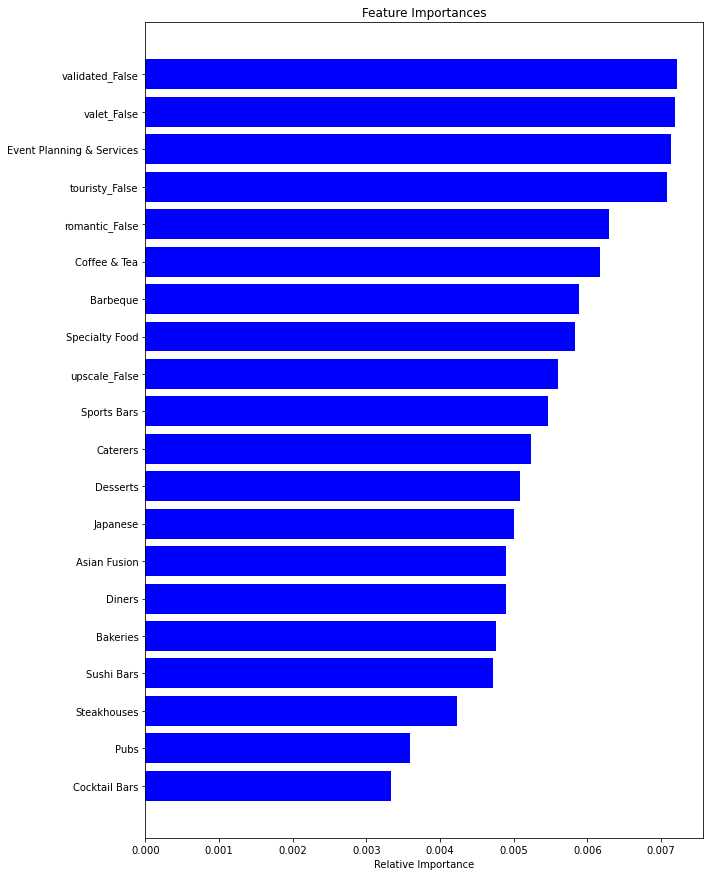

In [14]:
#plotting best features with random forest

model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model.fit(xTrain, yTrain)
# plotting feature importances
features = dataColumns
importances = model.feature_importances_
indices = np.argsort(importances)
indices = indices[0:20]
plt.figure(figsize=(10,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.savefig("FeatImportance.png")
#plt.show()
